In [2]:
import allel
import numpy as np
import pandas as pd

In [9]:
## besides nsl all the other stats require a genetic map, for that we need recombination stats, i found one on the internt from this paper   https://academic.oup.com/g3journal/article/10/10/3701/6053539?login=false


In [6]:
vcf = allel.read_vcf('modern_imputed.vcf.gz', fields=['variants/CHROM', 'variants/POS'])

In [7]:
snps = pd.concat([pd.Series(vcf['variants/CHROM']), pd.Series(vcf['variants/POS'])],axis=1)
snps.columns = ['chr', 'pos']

In [8]:
## generate a genetic map to run other selection scans
## there is one here https://datadryad.org/dataset/doi:10.5061/dryad.c2fqz614w

import pandas as pd
genetic_map = pd.read_csv("INRA_NAM_joint_linkage_map.csv")

In [2]:
# Extract bp from marker and keep chr/cM
genmap['bp'] = genmap['marker'].str.split('_').str[1].astype(int)

# Keep only necessary columns and sort
genmap = genmap[['chr', 'bp', 'cM']].sort_values(['chr', 'bp'])

In [4]:
genmap.to_csv('genetic_map.csv',index=None)

In [80]:
## interpolate values to have a complete map 
def interpolate_map(snps_chr, map_chr):
    # Must have at least 2 points to interpolate
    if map_chr.shape[0] < 2:
        snps_chr['cM'] = np.nan
        return snps_chr
    # Interpolate genetic position using numpy
    snps_chr['cM'] = np.interp(
        snps_chr['pos'],
        map_chr['bp'],
        map_chr['cM']
    )
    return snps_chr


In [78]:
snps['chr'] = snps['chr'].astype(int)

In [81]:
# Apply by chromosome
snps_interp = (
    snps.groupby('chr')
    .apply(lambda df: interpolate_map(df.copy(), genmap[genmap['chr'] == df.name]))
    .reset_index(drop=True)
)

In [82]:
snps_interp['cM'].notna().sum()

1448536

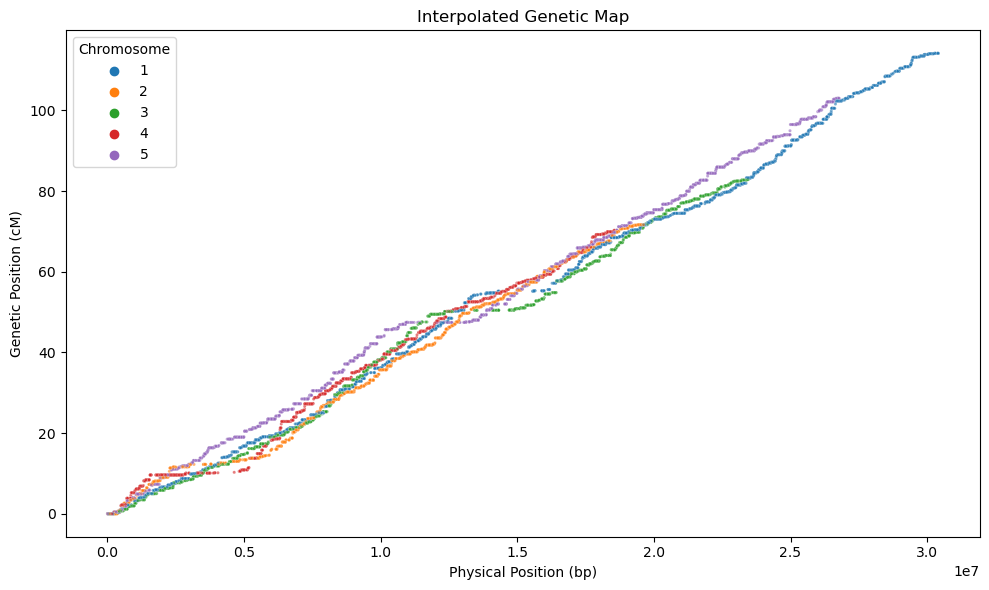

In [84]:
## check that the genetic and phisical distance make sense 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=snps_interp.sample(10000), x='pos', y='cM', hue='chr', palette='tab10', s=5, alpha=0.6)
plt.xlabel('Physical Position (bp)')
plt.ylabel('Genetic Position (cM)')
plt.title('Interpolated Genetic Map')
plt.legend(title='Chromosome')
plt.tight_layout()
plt.show()


In [87]:
snps_interp['snp_id'] = '.'

In [91]:
snps_interp = snps_interp[['chr', 'snp_id', 'cM', 'pos']]

In [ ]:
## sabe tehr esults 

In [92]:
snps_interp.to_csv("selscan_ready.map", sep='\t', index=False, header=False)

In [96]:
# Save per chromosome .map files
for chr_num in range(1, 6):
    chr_df = snps_interp[snps_interp["chr"] == chr_num]
    chr_df.to_csv(f"selscan_chr{chr_num}.map", sep='\t', index=False, header=False)
